In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

C:\Users\1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/ssd_300_vgg.ckpt


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

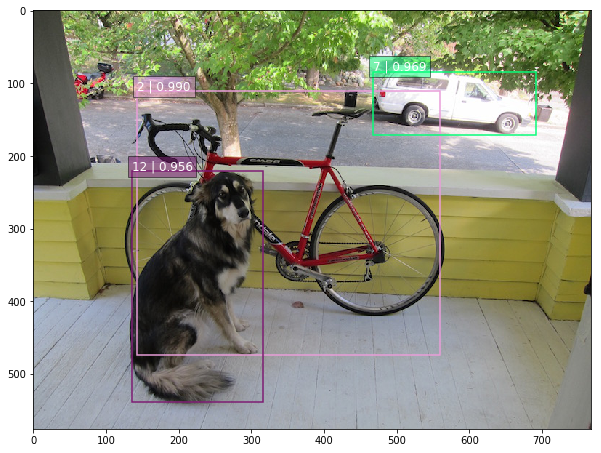

In [8]:
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))

img = mpimg.imread(path + image_names[-5])
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [9]:
import numpy as np
import cv2

#cap = cv2.VideoCapture('Flipped.2010.BRRip.XviD.MP3-RARBG.avi')
#for i in range(3000):
#    cap.read()

cap = cv2.VideoCapture(0)


    
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # bgr to rgb code  (2 way : split-merge, sliding)
    #f_b, f_g, f_r = cv2.split(frame)
    #f_rgb = cv2.merge([f_r, f_g, f_b])
    f_rgb = frame[...,::-1]
    
    # rgb 변환 확인용...
    #cv2.imshow("f_rgb", f_rgb)
    
    # Our operations on the frame come here
    rclasses, rscores, rbboxes = process_image(img=f_rgb,                      # 처리할 이미지
                                               select_threshold=0.5,           # 임계점.
                                               nms_threshold=.45,              # 임계점
                                               net_shape=(512, 512))           # model input image size
    
    visualization.bboxes_draw_on_img(frame, rclasses, rscores, rbboxes, visualization.colors_plasma)
  
    
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
   

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable

In [11]:
import cv2
#실행시킬 동영상 주소를 입력한다.
cap = cv2.VideoCapture('222.mp4')

#\앞 부분(500 프레임)을 스킵함.
for i in range(1000):
    cap.read()
#웹캠을 사용할 경우.
##cap = cv2.VideoCapture(0)


while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # bgr to rgb... openCV는 이미지를 bgr순으로 읽어와서 바꿔줘야 한다.
    f_rgb = frame[...,::-1]

    #이 부분이 딥러닝을 통해서 이미지의 클래스와, 그 점수, 위치를 받아온다.
    rclasses, rscores, rbboxes = process_image(f_rgb)

    #이미지에 상자 형식으로 덧붙인다.
    visualization.bboxes_draw_on_img(frame, rclasses, rscores, rbboxes, visualization.colors_plasma)

    # Display the resulting frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()## 




KeyboardInterrupt: 

In [ ]:
"""
     1.   'aeroplane'
    2.   'bicycle'
    3.   'bird'
    4.   'boat'
    5    'bottle'
    6    'bus'
    7    'car'
    8    'cat'
    9    'chair'
    10 'cow'
    11 'diningtable'
    12 'dog'
    13 'horse'
    14 'motorbike'
    15 'person'
    16 'pottedplant'
    17 'sheep'
    18 'sofa'
    19 'train'
    20 'tvmonitor


"""